## SpaceShip Titanic 

Réalisé par : Imane BOUKHARI,
Lynda CHABOUNI,
Léo BEN HATAT,
Khady CAMARA DANSO

# 1. Etude préalable des données 
## 1.1. Analyse des fichiers 

Librairies et extensions 

In [335]:
import pandas as pd  # pandas is used for data manipulation and analysis, providing data structures like DataFrames.
import numpy as np  # numpy is used for numerical operations on large, multi-dimensional arrays and matrices.
import seaborn as sns  # seaborn is used for making statistical graphics in Python.
import matplotlib.pyplot as plt # matplotlib.pyplot is used for creating static, interactive, and animated visualizations in Python.
from matplotlib.ticker import FuncFormatter  # FuncFormatter is used for formatting tick labels on matplotlib plots.

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency
sns.set(style="whitegrid")


Importation des données

In [336]:
chemin = 'Données/train.csv'
train_data = pd.read_csv(chemin)

chemin = 'Données/test.csv'
test_data = pd.read_csv(chemin)

display(train_data.head())
print(f'The shape of the train dataset is {train_data.shape}')
print(f'The shape of the test dataset is {test_data.shape}\n')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The shape of the train dataset is (8693, 14)
The shape of the test dataset is (4277, 13)



Liste des variables présentes dans le dataset

| **Nom de la variable** | **Description** |
|:----------------------:|:---------------:|
| PassengerId | Un identifiant unique pour chaque passager. Chaque identifiant prend la forme de gggg_pp, où gggg indique le groupe avec lequel le passager voyage et pp est son numéro au sein du groupe. Les membres d'un groupe sont souvent des membres de la famille, mais pas toujours. |
| HomePlanet | La planète d'où le passager est parti, généralement sa planète de résidence permanente. |
| CryoSleep | Indique si le passager a choisi d'être mis en animation suspendue pendant la durée du voyage. Les passagers en cryosleep sont confinés dans leurs cabines. |
| Cabin | Le numéro de cabine où le passager séjourne. Il prend la forme de pont/numéro/côté, où le côté peut être soit P pour bâbord, soit S pour tribord. (deck/num/side) |
| Destination | Planète de destination |
| Age | Âge du passager |
| VIP | Indique si le passager a payé pour un service VIP spécial pendant le voyage. |
| RoomService | Dépenses en Room Service |
| FoodCourt | Dépenses au Food Court |
| ShoppingMall | Dépenses au Shopping Mall |
| Spa | Dépenses au Spa |
| VRDeck | Dépenses au VR Deck |
| Name | Prénom et nom du passager |
| Transported |  Indique si le passager a été transporté vers une autre dimension. Il s'agit de la cible, la colonne que vous essayez de prédire. |

# 1.2 Traitement des valeurs manquantes et aberrantes

In [337]:
# Statistiques descriptives globales
stats = train_data.describe(include='all').T
stats['% de valeurs manquantes'] = 100 * train_data.isnull().sum() / len(train_data)
display(stats)

# Tableau synthétique des valeurs manquantes
manquantes = pd.DataFrame({
    'Nom': train_data.columns,
    'Total de valeurs': len(train_data),
    'Total de valeurs manquantes': train_data.isnull().sum().values,
    'Pourcentage de valeurs manquantes': 100 * train_data.isnull().sum().values / len(train_data)
})
manquantes = manquantes[manquantes['Total de valeurs manquantes'] > 0]
manquantes = manquantes[['Nom', 'Total de valeurs', 'Total de valeurs manquantes', 'Pourcentage de valeurs manquantes']]
manquantes.sort_values('Total de valeurs manquantes', ascending=False, inplace=True)
display(manquantes.style.format({'Pourcentage de valeurs manquantes': '{:.2f}%'}).set_caption('Valeurs manquantes par variable'))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,% de valeurs manquantes
PassengerId,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.312205
CryoSleep,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.496261
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.289198
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.093639
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0,2.059128
VIP,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.335212
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0,2.082135
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0,2.105142
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0,2.392730


,Nom,Total de valeurs,Total de valeurs manquantes,Pourcentage de valeurs manquantes
2,CryoSleep,8693,217,2.50%
9,ShoppingMall,8693,208,2.39%
6,VIP,8693,203,2.34%
1,HomePlanet,8693,201,2.31%
12,Name,8693,200,2.30%
3,Cabin,8693,199,2.29%
11,VRDeck,8693,188,2.16%
8,FoodCourt,8693,183,2.11%
10,Spa,8693,183,2.11%
4,Destination,8693,182,2.09%


Vérification des doublons

In [338]:
duplicates = train_data.duplicated()
print("\nNumber of duplicates :", duplicates.sum())

if duplicates.any():
    print("\nLines with duplicates :")
    print(train_data[duplicates])


Number of duplicates : 0


Nous visualisons la distribution des variables numériques et détectons les valeurs aberrantes à l'aide de la méthode de l'IQR. Les outliers sont remplacés par la médiane pour préserver la distribution.

In [339]:
num_cols = train_data.select_dtypes(include=np.number).columns
for col in num_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((train_data[col] < lower) | (train_data[col] > upper)).sum()
    print(f"{col} : {outliers} valeurs aberrantes détectées")
    mediane = train_data[col].median()
    train_data.loc[train_data[col] < lower, col] = mediane
    train_data.loc[train_data[col] > upper, col] = mediane

Age : 77 valeurs aberrantes détectées
RoomService : 1861 valeurs aberrantes détectées
FoodCourt : 1823 valeurs aberrantes détectées
ShoppingMall : 1829 valeurs aberrantes détectées
Spa : 1788 valeurs aberrantes détectées
VRDeck : 1809 valeurs aberrantes détectées


In [340]:

# Columnas numéricas
num_cols = train_data.select_dtypes(include=np.number).columns

# Diccionario que guardará las máscaras de outliers por columna
outlier_cols = {}

# Máscara global para filas que son outliers en al menos una columna
outlier_mask = pd.Series(False, index=train_data.index)

for col in num_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (train_data[col] < lower) | (train_data[col] > upper)
    outlier_cols[col] = mask
    outlier_mask = outlier_mask | mask

# DataFrame con todas las filas que tienen al menos un outlier
df_outliers = train_data[outlier_mask].copy()

# Añadir columna que lista las columnas donde cada fila es outlier
df_outliers['OutlierColumns'] = df_outliers.index.to_series().apply(lambda i: [col for col, m in outlier_cols.items() if m.loc[i]])

# Flag booleano
df_outliers

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,OutlierColumns
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,0.0,44.0,Juanna Vines,True,"[RoomService, FoodCourt, ShoppingMall, VRDeck]"
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,0.0,0.0,0.0,49.0,Altark Susent,False,"[RoomService, VRDeck]"
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,0.0,70.0,0.0,0.0,2.0,Willy Santantines,True,"[FoodCourt, VRDeck]"
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,0.0,3.0,0.0,0.0,Billex Jacostaffey,True,"[RoomService, ShoppingMall]"
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,0.0,17.0,0.0,0.0,Andona Beston,True,[ShoppingMall]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,9275_02,Europa,False,A/97/P,TRAPPIST-1e,32.0,False,1.0,0.0,0.0,50.0,34.0,Diram Conable,False,"[RoomService, Spa, VRDeck]"
8687,9275_03,Europa,NaN,A/97/P,TRAPPIST-1e,30.0,False,0.0,0.0,0.0,2.0,0.0,Atlasym Conable,True,[Spa]
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,0.0,0.0,0.0,74.0,Gravior Noxnuther,False,[VRDeck]
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,1.0,0.0,Fayey Connon,True,[Spa]


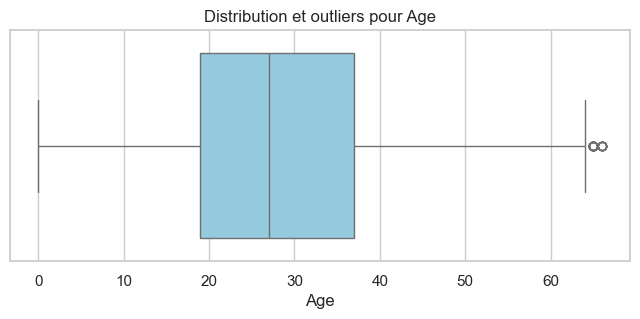

Age : 30 valeurs aberrantes détectées


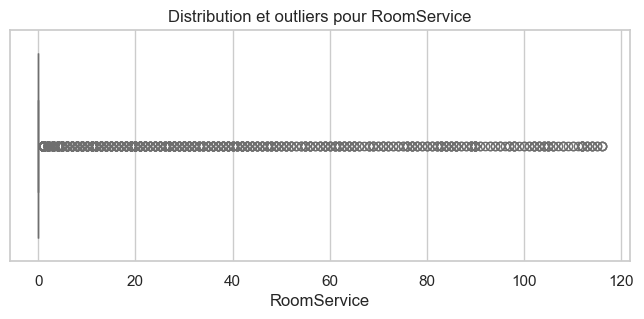

RoomService : 1074 valeurs aberrantes détectées


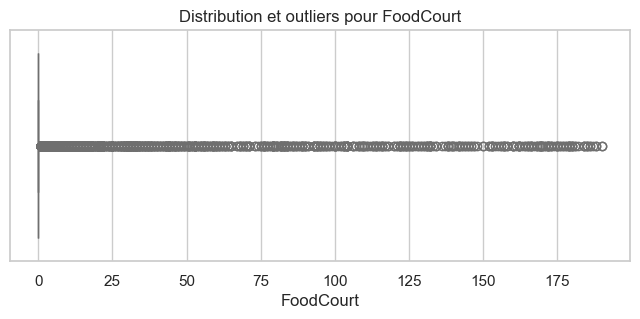

FoodCourt : 1231 valeurs aberrantes détectées


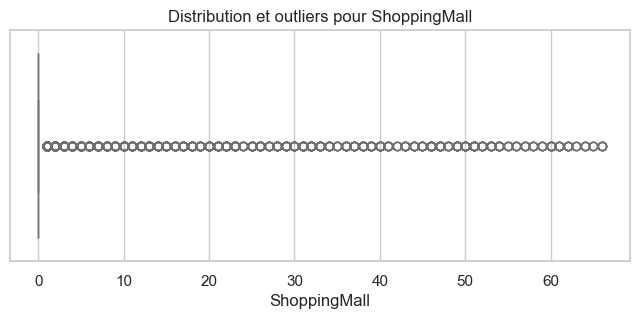

ShoppingMall : 1069 valeurs aberrantes détectées


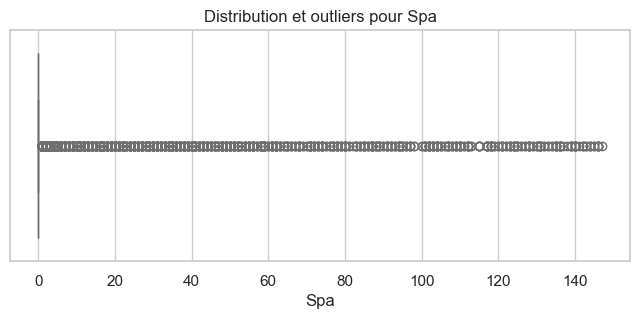

Spa : 1398 valeurs aberrantes détectées


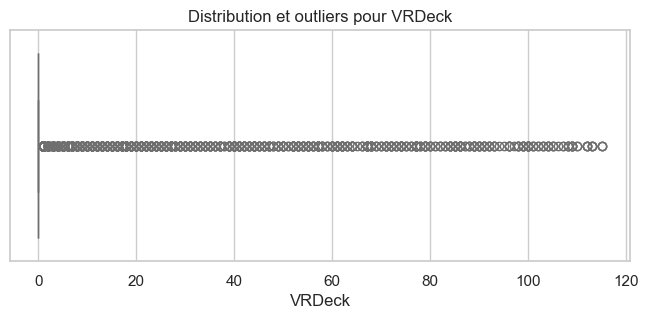

VRDeck : 1201 valeurs aberrantes détectées


In [341]:
num_cols = train_data.select_dtypes(include=np.number).columns
for col in num_cols:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=train_data[col], color='skyblue')
    plt.title(f'Distribution et outliers pour {col}')
    plt.show()
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((train_data[col] < lower) | (train_data[col] > upper)).sum()
    print(f"{col} : {outliers} valeurs aberrantes détectées")
    mediane = train_data[col].median()
    train_data.loc[train_data[col] < lower, col] = mediane
    train_data.loc[train_data[col] > upper, col] = mediane

## 1.3 Variables ajoutées

In [342]:
##########TRAIN  -------------------------------

# A. Exploitation de PassengerId (Group & IsAlone)
train_data['Group'] = train_data['PassengerId'].str.split('_').str[0]

train_data['GroupSize'] = train_data.groupby('Group')['Group'].transform('count')

train_data['IsAlone'] = (train_data['GroupSize'] == 1).astype(int)


# B. Découpage de la cabine (Deck, Num, Side)
train_data[['Deck', 'CabinNum', 'Side']] = train_data['Cabin'].str.split('/', expand=True)


# C. Analyse des dépenses
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_data['TotalSpent'] = train_data[exp_features].sum(axis=1)

train_data['HasSpent'] = (train_data['TotalSpent'] > 0).astype(int)


# D. Nom de famille et taille de la famille
train_data['FamilyName'] = train_data['Name'].str.split().str[-1]

train_data['FamilySize'] = train_data.groupby('FamilyName')['FamilyName'].transform('count')

train_data['HasFamily'] = (train_data['FamilySize'] > 1).astype(int)



##########TEST --------------------------------------

# A. Exploitation de PassengerId (Group & IsAlone)

test_data['Group'] = test_data['PassengerId'].str.split('_').str[0]

test_data['GroupSize'] = test_data.groupby('Group')['Group'].transform('count')

test_data['IsAlone'] = (test_data['GroupSize'] == 1).astype(int)


# B. Découpage de la cabine (Deck, Num, Side)
test_data[['Deck', 'CabinNum', 'Side']] = test_data['Cabin'].str.split('/', expand=True)


# C. Analyse des dépenses
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

test_data['TotalSpent'] = test_data[exp_features].sum(axis=1)

test_data['HasSpent'] = (test_data['TotalSpent'] > 0).astype(int)


# D. Nom de famille et taille de la famille
test_data['FamilyName'] = test_data['Name'].str.split().str[-1]

test_data['FamilySize'] = test_data.groupby('FamilyName')['FamilyName'].transform('count')

test_data['HasFamily'] = (test_data['FamilySize'] > 1).astype(int)


# Drop the Cabin columns 
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

# Vérification rapide
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,GroupSize,IsAlone,Deck,CabinNum,Side,TotalSpent,HasSpent,FamilyName,FamilySize,HasFamily
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,1,1,B,0,P,0.0,0,Ofracculy,1.0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,...,1,1,F,0,S,0.0,0,Vines,4.0,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,0.0,0.0,0.0,0.0,...,2,0,A,0,S,0.0,0,Susent,6.0,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,...,2,0,A,0,S,0.0,0,Susent,6.0,1
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,...,1,1,F,1,S,0.0,0,Santantines,6.0,1


## 1.4 Imputation des valeurs manquantes 

Les valeurs manquantes sont imputées : la médiane pour les variables numériques et la modalité la plus fréquente (mode) pour les variables catégorielles. Cette étape est essentielle pour garantir la qualité des analyses ultérieures.

In [343]:
data = pd.concat([train_data.drop('Transported', axis=1), test_data], ignore_index=True)

#TRAIN 
train_data['HomePlanet'] = train_data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])  # Replace with the mode
train_data['CryoSleep'] = train_data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])  # Replace with the mode
train_data['Destination'] = train_data['Destination'].fillna(data['Destination'].mode()[0])  # Replace with the mode
train_data['Age'] = train_data['Age'].fillna(data['Age'].mean())  # Replace with the mean
train_data['VIP'] = train_data['VIP'].fillna(data['VIP'].mode()[0])  # Replace with the mode, which is False
train_data['RoomService'] = train_data['RoomService'].fillna(data['RoomService'].mean())  # Replace with the mean
train_data['FoodCourt'] = train_data['FoodCourt'].fillna(data['FoodCourt'].mean())  # Replace with the mean
train_data['ShoppingMall'] = train_data['ShoppingMall'].fillna(data['ShoppingMall'].mean())  # Replace with the mean
train_data['Spa'] = train_data['Spa'].fillna(data['Spa'].mean())  # Replace with the mean
train_data['VRDeck'] = train_data['VRDeck'].fillna(data['VRDeck'].mean())  # Replace with the mean

# TEST
test_data['HomePlanet'] = test_data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])  # Replace with the mode
test_data['CryoSleep'] = test_data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])  # Replace with the mode
test_data['Destination'] = test_data['Destination'].fillna(data['Destination'].mode()[0])  # Replace with the mode
test_data['Age'] = test_data['Age'].fillna(data['Age'].mean())  # Replace with the mean
test_data['VIP'] = test_data['VIP'].fillna(data['VIP'].mode()[0])  # Replace with the mode, which is False
test_data['RoomService'] = test_data['RoomService'].fillna(data['RoomService'].mean())  # Replace with the mean
test_data['FoodCourt'] = test_data['FoodCourt'].fillna(data['FoodCourt'].mean())  # Replace with the mean
test_data['ShoppingMall'] = test_data['ShoppingMall'].fillna(data['ShoppingMall'].mean())  # Replace with the mean
test_data['Spa'] = test_data['Spa'].fillna(data['Spa'].mean())  # Replace with the mean
test_data['VRDeck'] = test_data['VRDeck'].fillna(data['VRDeck'].mean())  # Replace with the mean


# Tableau synthétique des valeurs manquantes
manquantes = pd.DataFrame({
    'Nom': train_data.columns,
    'Total de valeurs': len(train_data),
    'Total de valeurs manquantes': train_data.isnull().sum().values,
    'Pourcentage de valeurs manquantes': 100 * train_data.isnull().sum().values / len(train_data)
})
manquantes = manquantes[manquantes['Total de valeurs manquantes'] > 0]
manquantes = manquantes[['Nom', 'Total de valeurs', 'Total de valeurs manquantes', 'Pourcentage de valeurs manquantes']]
manquantes.sort_values('Total de valeurs manquantes', ascending=False, inplace=True)
display(manquantes.style.format({'Pourcentage de valeurs manquantes': '{:.2f}%'}).set_caption('Valeurs manquantes par variable'))

,Nom,Total de valeurs,Total de valeurs manquantes,Pourcentage de valeurs manquantes
11,Name,8693,200,2.30%
21,FamilyName,8693,200,2.30%
22,FamilySize,8693,200,2.30%
16,Deck,8693,199,2.29%
17,CabinNum,8693,199,2.29%
18,Side,8693,199,2.29%


In [344]:


# TRAIN
# Groups where there is someone whose Cabin was missing
indices_groups_missing_cabin = train_data[train_data['Deck'].isnull()]['PassengerId'].values  # PassengerIds of the passengers with the missing cabin

# We can expect that memebers of the same group would share the same cabin deck, 
# number, and side
global_mode = data[['Deck', 'CabinNum', 'Side']].mode().iloc[0]  # Global mode of cabin deck, num, and side

for index in indices_groups_missing_cabin:
    group = index.split('_')[0]  # Number of the group with the member missing the cabin
    group_df = data[data['Group'] == group]  # df with the members of the group
    try:
        # Cabin Deck, Num, and Side mode for each group
        cabin_group_mode = group_df[~group_df['CabinNum'].isnull()][['Deck', 'CabinNum', 'Side']].mode().iloc[0]  
        # Replace the missing CabinNum with the mode in that group
        train_data.loc[train_data['PassengerId'] == index, ['Deck', 'CabinNum', 'Side']] = cabin_group_mode.values 
    except IndexError:
        # If there is just one member in a group and it misses the cabin, replace it with the global mode
        train_data.loc[train_data['PassengerId'] == index, ['Deck', 'CabinNum', 'Side']] = global_mode.values


# TRAIN
# Groups where there is someone whose Cabin was missing
indices_groups_missing_cabin = test_data[test_data['Deck'].isnull()]['PassengerId'].values  # PassengerIds of the passengers with the missing cabin

# We can expect that memebers of the same group would share the same cabin deck, 
# number, and side
global_mode = data[['Deck', 'CabinNum', 'Side']].mode().iloc[0]  # Global mode of cabin deck, num, and side

for index in indices_groups_missing_cabin:
    group = index.split('_')[0]  # Number of the group with the member missing the cabin
    group_df = data[data['Group'] == group]  # df with the members of the group
    try:
        # Cabin Deck, Num, and Side mode for each group
        cabin_group_mode = group_df[~group_df['CabinNum'].isnull()][['Deck', 'CabinNum', 'Side']].mode().iloc[0]  
        # Replace the missing CabinNum with the mode in that group
        test_data.loc[test_data['PassengerId'] == index, ['Deck', 'CabinNum', 'Side']] = cabin_group_mode.values 
    except IndexError:
        # If there is just one member in a group and it misses the cabin, replace it with the global mode
        test_data.loc[test_data['PassengerId'] == index, ['Deck', 'CabinNum', 'Side']] = global_mode.values



In [345]:
# Check
print('Train data\n\n', train_data.isnull().sum(), '\n')
print('Test data\n\n', test_data.isnull().sum())

Train data

 PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
Group             0
GroupSize         0
IsAlone           0
Deck              0
CabinNum          0
Side              0
TotalSpent        0
HasSpent          0
FamilyName      200
FamilySize      200
HasFamily         0
dtype: int64 

Test data

 PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name            94
Group            0
GroupSize        0
IsAlone          0
Deck             0
CabinNum         0
Side             0
TotalSpent       0
HasSpent         0
FamilyName      94
FamilySize      94
HasFamily        0
dtype: int64


# 1.3 Data types

In [346]:

train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep          bool
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Group            object
GroupSize         int64
IsAlone           int32
Deck             object
CabinNum         object
Side             object
TotalSpent      float64
HasSpent          int32
FamilyName       object
FamilySize      float64
HasFamily         int32
dtype: object

In [347]:
train_data['Group'] = train_data['Group'].astype(int)
test_data['Group'] = test_data['Group'].astype(int)

train_data['PassengerId'] = train_data['PassengerId'].astype(int)
test_data['PassengerId'] = test_data['PassengerId'].astype(int)

train_data['CryoSleep'] = train_data['CryoSleep'].astype(int)
test_data['CryoSleep'] = test_data['CryoSleep'].astype(int)

train_data['VIP'] = train_data['VIP'].astype(int)
test_data['VIP'] = test_data['VIP'].astype(int)

train_data['CabinNum'] = train_data['CabinNum'].astype(int)
test_data['CabinNum'] = test_data['CabinNum'].astype(int)

train_data['Transported'] = train_data['Transported'].astype(int)

# The values in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck columns
# are all integers except for the mean values used to replace the missing data.
# So we can set the type of them to int
train_data['RoomService'] = train_data['RoomService'].astype(int)
test_data['RoomService'] = test_data['RoomService'].astype(int)

train_data['FoodCourt'] = train_data['FoodCourt'].astype(int)
test_data['FoodCourt'] = test_data['FoodCourt'].astype(int)

train_data['ShoppingMall'] = train_data['ShoppingMall'].astype(int)
test_data['ShoppingMall'] = test_data['ShoppingMall'].astype(int)

train_data['Spa'] = train_data['Spa'].astype(int)
test_data['Spa'] = test_data['Spa'].astype(int)

train_data['VRDeck'] = train_data['VRDeck'].astype(int)
test_data['VRDeck'] = test_data['VRDeck'].astype(int)

# 2. Statistiques descriptives

## 2.1 Statistiques Univariées

### 2.1.1 Variables numériques 

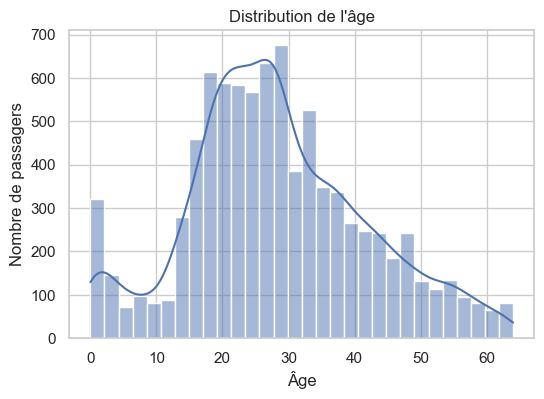

In [348]:
plt.figure(figsize=(6,4))
sns.histplot(train_data['Age'], bins=30, kde=True)
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Nombre de passagers")
plt.show()


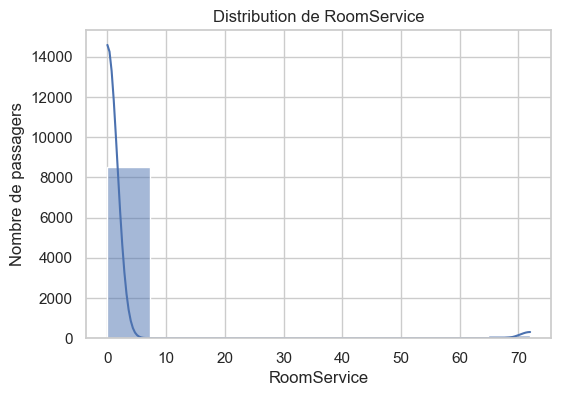

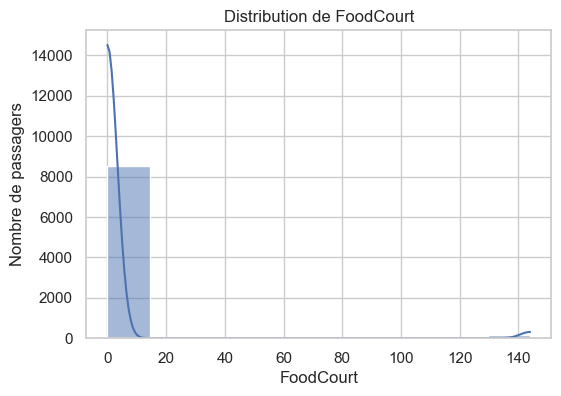

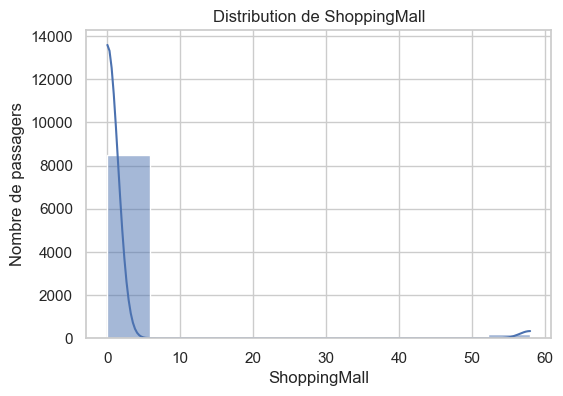

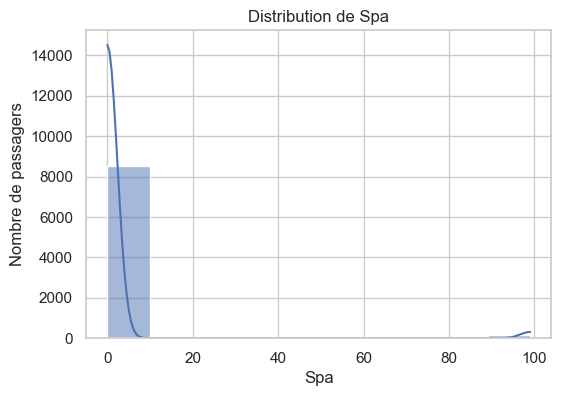

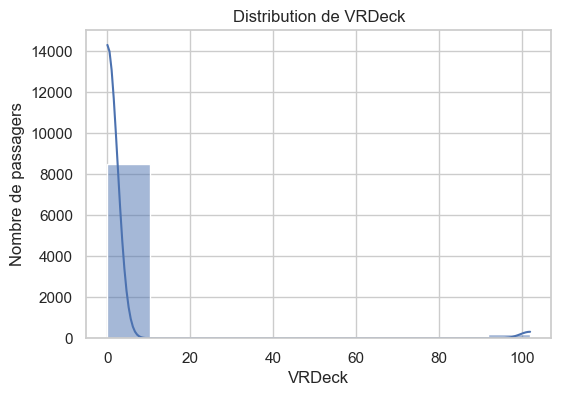

In [349]:
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in exp_features:
    plt.figure(figsize=(6,4))
    sns.histplot(train_data[col], bins=10, kde=True)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre de passagers")
    plt.show()


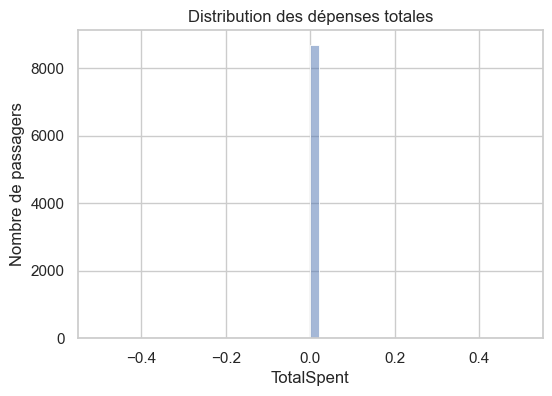

In [350]:
plt.figure(figsize=(6,4))
sns.histplot(train_data['TotalSpent'], bins=50, kde=True)
plt.title("Distribution des dépenses totales")
plt.xlabel("TotalSpent")
plt.ylabel("Nombre de passagers")
plt.show()


### 2.1.2 Variables catégorielles 

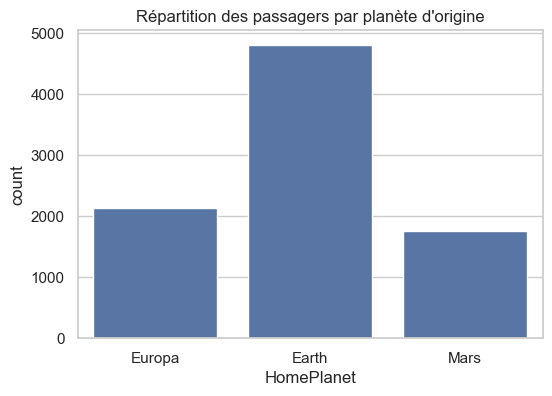

In [351]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_data, x='HomePlanet')
plt.title("Répartition des passagers par planète d'origine")
plt.show()


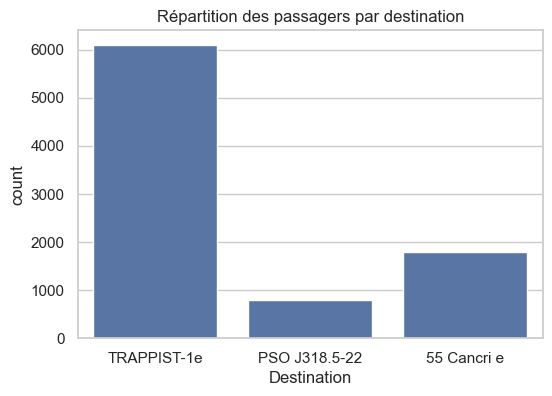

In [352]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_data, x='Destination')
plt.title("Répartition des passagers par destination")
plt.show()


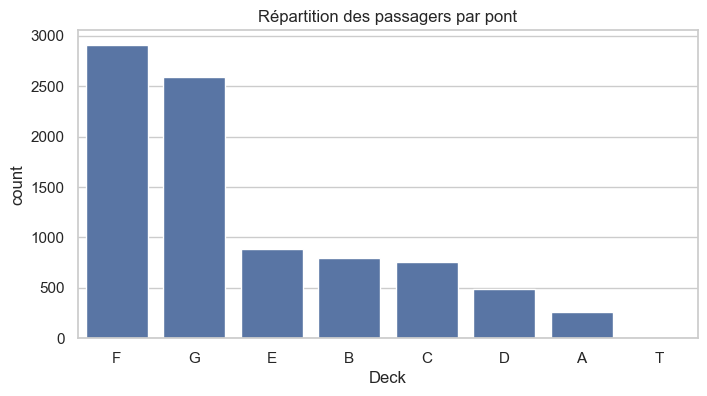

In [353]:
plt.figure(figsize=(8,4))
sns.countplot(data=train_data, x='Deck', order=train_data['Deck'].value_counts().index)
plt.title("Répartition des passagers par pont")
plt.show()


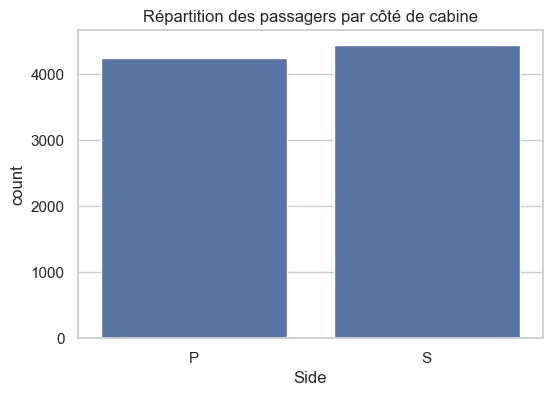

In [354]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_data, x='Side')
plt.title("Répartition des passagers par côté de cabine")
plt.show()


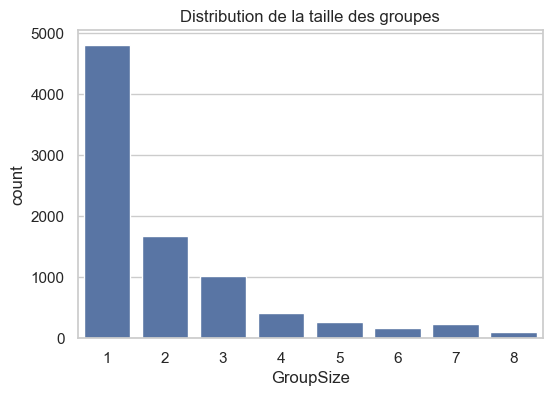

In [355]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_data, x='GroupSize')
plt.title("Distribution de la taille des groupes")
plt.show()


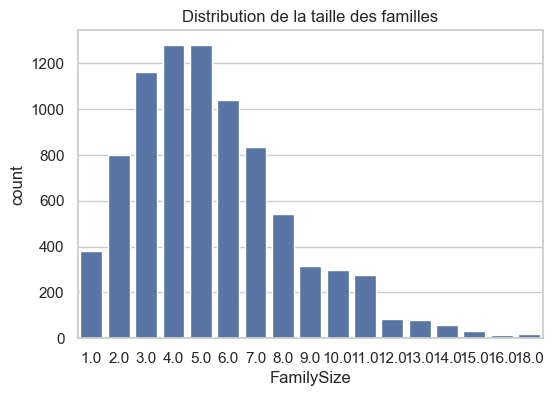

In [356]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_data, x='FamilySize')
plt.title("Distribution de la taille des familles")
plt.show()


### 2.1.3 Variables binaires

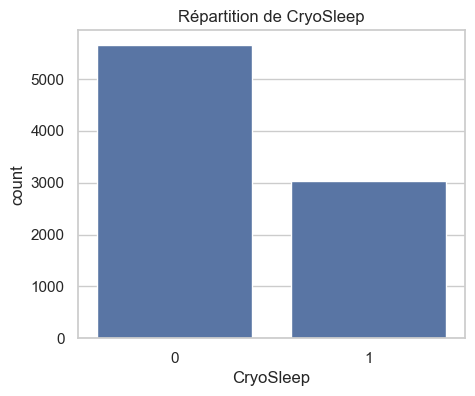

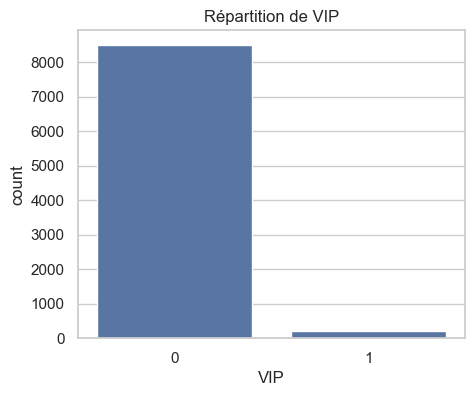

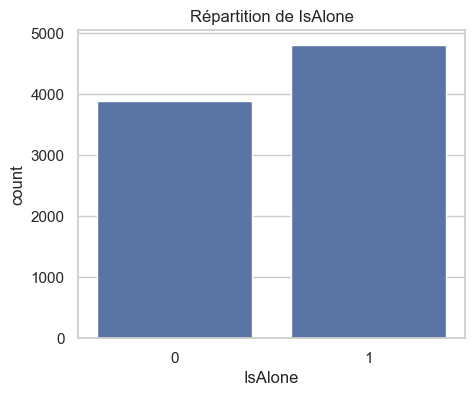

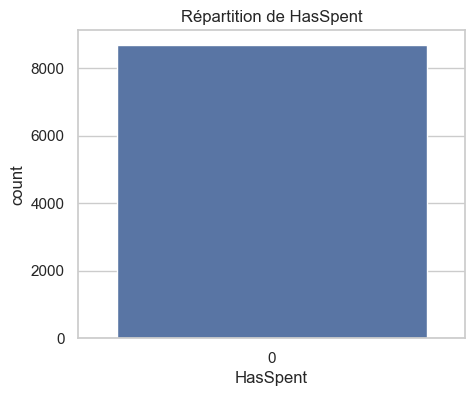

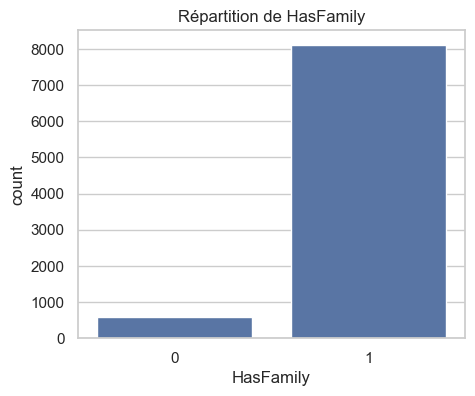

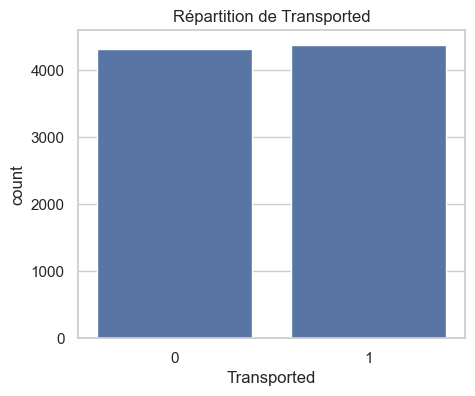

In [357]:
binary_vars = [
    'CryoSleep', 'VIP', 'IsAlone', 'HasSpent', 'HasFamily', 'Transported'
]

for col in binary_vars:
    plt.figure(figsize=(5,4))
    sns.countplot(data=train_data, x=col)
    plt.title(f"Répartition de {col}")
    plt.show()


## 2.2 Statistiques bivariées 

Verification de la coherence des données (cryogénisé et depenses)

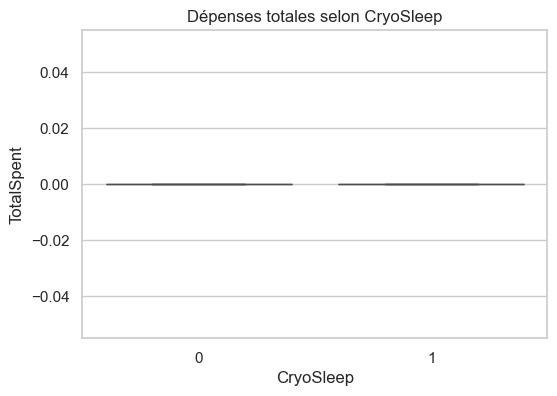

In [358]:
plt.figure(figsize=(6,4))
sns.boxplot(data=train_data, x='CryoSleep', y='TotalSpent')
plt.title("Dépenses totales selon CryoSleep")
plt.show()


Analyse des relations entre variables catégorielles avec le V de Cramer

Nous analysons la force des relations entre les variables catégorielles à l'aide du V de Cramer et visualisons la matrice de corrélation obtenue. La diagonale est fixée à 1 pour une meilleure lisibilité.

In [359]:
# ================================
# SELECTION DES VARIABLES CATEGORIELLES
# ================================
# Exclure les colonnes à trop forte cardinalité
cat_cols = [
    'HomePlanet',
    'CryoSleep',
    'Destination',
    'VIP',
    'Deck',
    'Side',
    'IsAlone',
    'HasSpent',
    'HasFamily',
    'Transported'
]

# ================================
# FONCTION V DE CRAMER
# ================================
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# ================================
# CALCUL DE LA MATRICE DE V DE CRAMER
# ================================
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramer_matrix = cramer_matrix.astype(float)
np.fill_diagonal(cramer_matrix.values, 1)

# ================================
# HEATMAP
# ================================
plt.figure(figsize=(10, 8))
sns.heatmap(
    cramer_matrix,
    annot=True,
    cmap='Blues',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Matrice de V de Cramér entre variables catégorielles")
plt.show()

NameError: name 'df' is not defined